## 1. Number of transactions per day

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import random
from pydantic import BaseModel, ValidationError
from typing import List
import uuid 
import numpy as np
from loguru import logger
import numpy as np
from datetime import datetime, timedelta
from typing import List
from utils import compute_lognormal_parameters

# Set seed for reproducibility
seed = 99


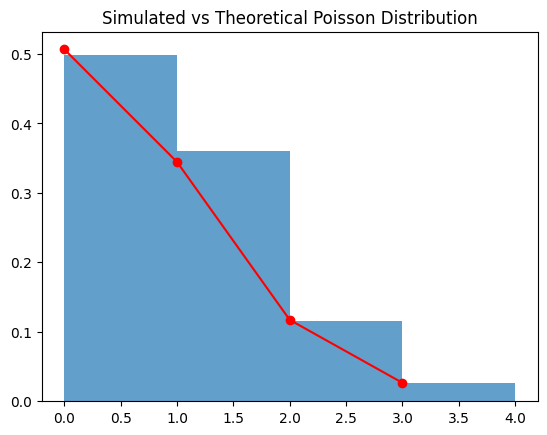

In [3]:
# 251 transactions per year = 0.68 transactions per day
daily_txn = np.random.poisson(0.68, size=1000)
plt.hist(daily_txn, bins=range(max(daily_txn)+2), density=True, alpha=0.7)
x = range(max(daily_txn)+1)
plt.plot(x, stats.poisson.pmf(x, 0.68), 'ro-')
plt.title('Simulated vs Theoretical Poisson Distribution')
plt.show()

## 2. Value of each transaction

In [4]:
# def compute_sigma(mean:float, cv:float) -> float:
#     """ 
#     a formula to calculate sigma from mean and CV
#     """
#     variance = (mean * cv)**2
#     sigma_sq = np.log(1 + variance/(mean**2))
#     sigma = np.sqrt(sigma_sq)
#     # get the value from numpy array
#     return sigma.item()

# def compute_lognormal_parameters(mean:float, cv:float):
#     """
#     Calculate mu and sigma for lognormal distribution given mean and cv.
#     Adapted from: https://www.johndcook.com/blog/2022/02/24/find-log-normal-parameters/

#     """
#     variance = (mean * cv)**2
#     sigma2 = np.log(1 + variance/(mean**2))
#     sigma = np.sqrt(sigma2)
#     mu = np.log(mean) - sigma2/2
#     return (mu.item(), sigma.item())


# def compute_sigma_v2(cv):
#     """ 
#     Calculate sigma given CV
#     the CV alone doesn't fully specify the distribution. 
#     You still need a measure of central tendency (like the mean) to "position" the distribution on the x-axis.
#     """
#     sigma = np.sqrt(np.log(1 + cv**2))
#     return sigma

In [5]:
compute_lognormal_parameters(96.49, 0.75)

(4.346295824718083, 0.6680472308365776)

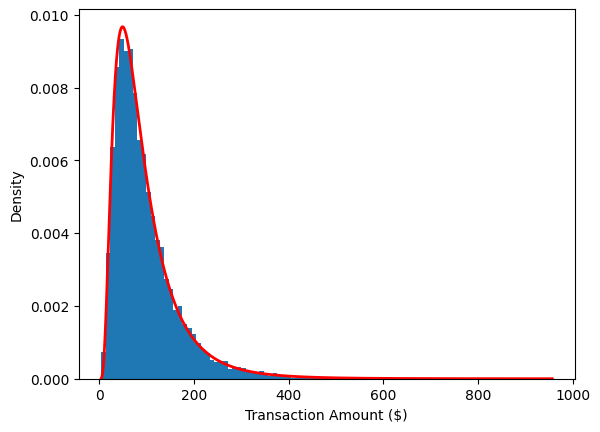

In [6]:
# Generate lognormal txn_value
mean_txn = 96.49 # mean of raw txn value
cv = 0.75 # coefficient of variation
mu, sigma = compute_lognormal_parameters(mean_txn, cv)
size = 10000

np.random.seed(seed)
txn_values = np.random.lognormal(mean=mu, sigma=sigma, size=size)

# Create histogram
count, bins, ignored = plt.hist(txn_values, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), size)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')

plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.show()

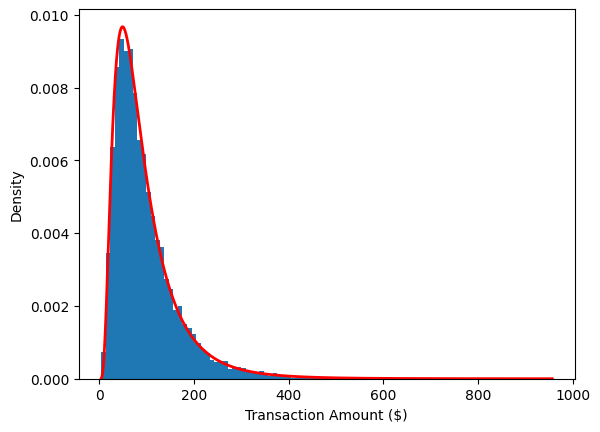

In [7]:
# Calculate PDF

np.random.seed(seed)
txn_values = np.random.lognormal(mean=mu, sigma=sigma, size=size)

# Create histogram
count, bins, ignored = plt.hist(txn_values, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), size)
pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(mu))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')

plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.show()

## 3. Consolidated Customer spending profile

In [8]:
# create a dictionary to contain profiles abvoe for the uniform distributions of mean and CV:
group_profiles = {
    'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
    'txn_mean_low': [5, 20, 40, 60, 80],
    'txn_mean_high': [20, 40, 60, 80, 100],
    'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
    'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
    'txn_lambda': [0.25, 0.5, 1, 1.5, 2] # to simplify, we assume middle income person has average 1 txn per day
}

class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]

# Validate the input dictionary using assert
try:
    validated_profiles = GroupProfiles(**group_profiles)
    assert validated_profiles
    print("Validation successful!")
except ValidationError as e:
    assert False, f"Validation failed: {e}"

# visualize in a table
df = pd.DataFrame(group_profiles)
df


Validation successful!


,name,txn_mean_low,txn_mean_high,txn_cv_low,txn_cv_high,txn_lambda
0,low,5,20,0.3,0.4,0.25
1,low-middle,20,40,0.4,0.5,0.50
2,middle,40,60,0.5,0.6,1.00
3,high-middle,60,80,0.6,0.7,1.50
4,high,80,100,0.7,0.8,2.00


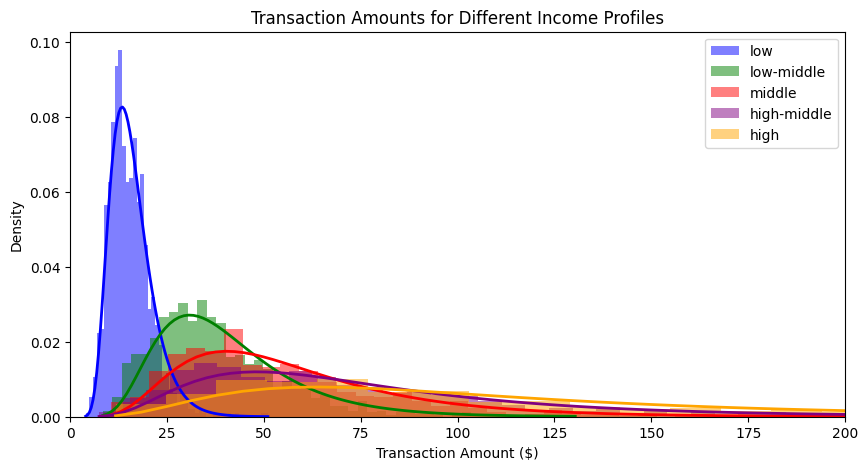

In [9]:
# Illustrating the spending habit of the groups above by generate 1000 transactions for a customer of each profile
np.random.seed(seed)

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(10, 5))
for i, profile in enumerate(df["name"]):
    row = df[df["name"] == profile].iloc[0]
    profile_dict = row.to_dict()

    mean_amount = np.random.uniform(profile_dict["txn_mean_low"], profile_dict["txn_mean_high"])
    cv = np.random.uniform(profile_dict["txn_cv_low"], profile_dict["txn_cv_high"])
    # sigma = compute_sigma(mean_amount, cv)
    # txn_value = np.random.lognormal(mean=np.log(mean_amount), sigma=sigma, size=1000)
    mu, sigma = compute_lognormal_parameters(mean_amount, cv)
    txn_value = np.random.lognormal(mean=mu, sigma=sigma, size=1000)
    
    # Plot histogram
    plt.hist(txn_value, bins=50, density=True, alpha=0.5, label=profile, color=colors[i])
    
    # Calculate and plot PDF
    x = np.linspace(txn_value.min(), txn_value.max(), 100)
    pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean_amount)))
    plt.plot(x, pdf, color=colors[i], lw=2)

plt.xlim(0, 200)
plt.title('Transaction Amounts for Different Income Profiles')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

## 4. Generator and Customer Classes

In [10]:
# find current time
from datetime import datetime
datetime.now()

# convert to string
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2025-03-03 23:35:46'

In [17]:
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import List
from datetime import datetime
from typing import Optional


class UUIDGenerator:
    """
    Helper class to generate UUIDs with a specified length of the UUID string.
    The UUID is generated using the uuid4 method and then truncated to the specified length.
    Optional to add prefix and suffix to the generated UUID, which will add to the total length.
    """

    def __init__(self, id_length: int = 10):
        self.id_length = id_length

    def generate_id(
        self, prefix: Optional[str] = "", suffix: Optional[str] = ""
    ) -> str:
        id = prefix + str(uuid.uuid4().hex)[: self.id_length] + suffix
        return id

class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]


class Customer:
    def __init__(self, profile: dict):
        self.profile = profile
        self._date_format = "%Y-%m-%d"
        self._timestamp_format = "%Y-%m-%d %H:%M:%S"
        self._big_ticket_proba = 0.005
        self._big_ticket_multiplier = 10  # Adjust the multiplier as needed
        self._uuid_generator = UUIDGenerator(id_length=10)

    def generate_txn_value(self):
        """
        Generate a single transaction value for a customer based on their profile
        In addition, there is a fixed probability (0.5%) of a big-ticket item
        """

        if (
            np.random.rand() < self._big_ticket_proba
        ):  # rand() generates from uniform [0,1), thus there is 0.5% chance that the value is less than 0.005

            # Generate a big-ticket item
            big_ticket_mean = self.profile["txn_mean"] * self._big_ticket_multiplier
            big_ticket_sigma = self.profile["txn_sigma"]
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(big_ticket_mean),
                    sigma=big_ticket_sigma,
                ),
                2,
            )
        else:
            # Generate a regular transaction
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(self.profile["txn_mean"]),
                    sigma=self.profile["txn_sigma"],
                ),
                2,
            )
        return txn_value

    def generate_current_txn(self):
        """
        Generate a single transaction for a customer based on their profile with the current timestamp
        """
        txn_value = self.generate_txn_value()
        txn_timestamp = datetime.now().strftime(self._timestamp_format)
        txn_date = datetime.now().strftime(self._date_format)
        return {
            "txn_id": self._uuid_generator.generate_id(prefix="t_"),
            "txn_timestamp": txn_timestamp,
            "txn_date": txn_date,
            "txn_value": txn_value,
            "txn_fraud": 0,
            "txn_fraud_scenario": 0,
        }

    def generate_batch_txns(
        self, start_date: str = "2024-01-01", num_days: int = 30
    ) -> List[dict]:
        """
        Gererate a list of customer transactions for a given number of days

        Parameters
        -----------
        start_date: str
            The starting date of the transactions in the format 'YYYY-MM-DD'
        num_days: int
            The number of days for which to generate transactions

        Returns
        --------
        List[dict]
            A list of dictionaries where each dictionary represents a transaction
        """
        batch_txns = []
        for day in range(num_days):
            num_txn = np.random.poisson(self.profile["txn_lambda"])
            if num_txn > 0:
                for _ in range(num_txn):
                    # Time of transaction: revolves around noontime, with std 20000 seconds. This is meant to simulate the fact that most transactions should occur during the day (e.g., grocery, gas, other shopping...)
                    time_txn = int(np.random.normal(86400 / 2, 20000))

                    if (time_txn > 0) and (time_txn < 86400):
                        txn_value = self.generate_txn_value()

                        txn_timestamp = datetime.fromtimestamp(
                            time_txn, tz=None
                        ) + timedelta(days=day)

                        txn_timestamp = datetime.strptime(
                            start_date, self._date_format
                        ) + timedelta(seconds=time_txn, days=day)

                        # convert to str and save
                        txn_date = txn_timestamp.strftime(self._date_format)
                        txn_timestamp = txn_timestamp.strftime(self._timestamp_format)
                        batch_txns.append(
                            {
                                "txn_id": self._uuid_generator.generate_id(prefix="t_"),
                                "txn_timestamp": txn_timestamp,
                                "txn_date": txn_date,
                                "txn_value": txn_value,
                                "txn_fraud": 0,
                                "txn_fraud_scenario": 0,
                            }
                        )
        return batch_txns


class CustomerGenerator:
    def __init__(self, group_profiles: dict):
        """
        Initialize the CustomerGenerator with a dictionary of group profiles.

        Parameters:
        -----------
        group_profiles: dict
            A dictionary containing the group profiles for generating customer transactions.
            The dictionary must have the following structure where the key names and their value types are compulsory:
            {
                'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
                'txn_mean_low': [5, 20, 40, 60, 80],
                'txn_mean_high': [20, 40, 60, 80, 100],
                'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
                'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
                'txn_lambda': [0.25, 0.5, 1, 1.5, 2]
            }

        """
        # validate the group_profiles
        try:
            GroupProfiles(**group_profiles)
        except ValidationError as e:
            raise ValueError(f"Invalid group_profiles data: {e}")

        self.group_profiles = self._convert_col_to_row_oriented_profile(
            group_profiles, "name"
        )

    def generate_customer_from_profile(self, profile_name: str):
        """
        Generate a customer object with a specific profile, modelled from the chosen profile name
        """
        assert profile_name in self.group_profiles.keys(), "Profile name not found"
        profile = self.group_profiles[profile_name]
        txn_mean = round(
            np.random.uniform(profile["txn_mean_low"], profile["txn_mean_high"]), 2
        )
        cv = round(np.random.uniform(profile["txn_cv_low"], profile["txn_cv_high"]), 2)
        # txn_sigma = round(self._compute_sigma(txn_mean, cv), 2)
        txn_mu, txn_sigma = compute_lognormal_parameters(txn_mean, cv)
        # round to 2 decimal places
        txn_sigma = txn_sigma
        txn_lambda = profile["txn_lambda"]
        customer_profile = {
            "txn_mean": txn_mean,
            "txn_mu": txn_mu,
            "txn_sigma": txn_sigma,
            "txn_lambda": txn_lambda,
        }
        return Customer(customer_profile)

    def _convert_col_to_row_oriented_profile(
        self, input_dict: dict, key_field: str
    ) -> dict:
        """
        Convert a column-oriented dictionary, which is more concise, to a row-oriented dictionary, which is easier to extract field-specific data from.

        Example:
        --------
        input_dict = {
            'key_field': ['A', 'B', 'C'],
            'field1': [1, 2, 3],
            'field2': [4, 5, 6]
        }
        output_dict = {
            'A': {'field1': 1, 'field2': 4},
            'B': {'field1': 2, 'field2': 5},
            'C': {'field1': 3, 'field2': 6}
        }
        """
        assert (
            key_field in input_dict
        ), f"Key field '{key_field}' not found in input dictionary"
        output_dict = {}
        key_values = input_dict[key_field]
        other_fields = {k: v for k, v in input_dict.items() if k != key_field}

        for i, key in enumerate(key_values):
            output_dict[key] = {
                field: values[i] for field, values in other_fields.items()
            }

        return output_dict




In [19]:
# testing the customer and batch transaction generation
profile_name = 'middle'
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile(profile_name)
print(profile_name)
print(customer.profile)

customer_txns = customer.generate_batch_txns(num_days=7)
customer_txns[:5]

middle
{'txn_mean': 58.52, 'txn_mu': 3.9455870982244465, 'txn_sigma': 0.4975569875450985, 'txn_lambda': 1}


[{'txn_id': 't_2c6bfa36fb',
  'txn_timestamp': '2024-01-01 19:41:59',
  'txn_date': '2024-01-01',
  'txn_value': 117.09,
  'txn_fraud': 0,
  'txn_fraud_scenario': 0},
 {'txn_id': 't_fb74bc226d',
  'txn_timestamp': '2024-01-01 18:03:55',
  'txn_date': '2024-01-01',
  'txn_value': 79.02,
  'txn_fraud': 0,
  'txn_fraud_scenario': 0},
 {'txn_id': 't_492975317c',
  'txn_timestamp': '2024-01-02 06:08:47',
  'txn_date': '2024-01-02',
  'txn_value': 86.9,
  'txn_fraud': 0,
  'txn_fraud_scenario': 0},
 {'txn_id': 't_e8a59788e7',
  'txn_timestamp': '2024-01-02 13:44:23',
  'txn_date': '2024-01-02',
  'txn_value': 91.21,
  'txn_fraud': 0,
  'txn_fraud_scenario': 0},
 {'txn_id': 't_cd7c111cb0',
  'txn_timestamp': '2024-01-03 10:34:43',
  'txn_date': '2024-01-03',
  'txn_value': 124.71,
  'txn_fraud': 0,
  'txn_fraud_scenario': 0}]

middle
{'txn_mean': 46.62, 'txn_mu': 3.6970399178573787, 'txn_sigma': 0.5384973830024288, 'txn_lambda': 1}
Average total transaction value: $1546.22
sample transactions
{'txn_id': 't_a7ce9ca3c4', 'txn_timestamp': '2024-01-01 10:08:52', 'txn_date': '2024-01-01', 'txn_value': 16.23, 'txn_fraud': 0, 'txn_fraud_scenario': 0}


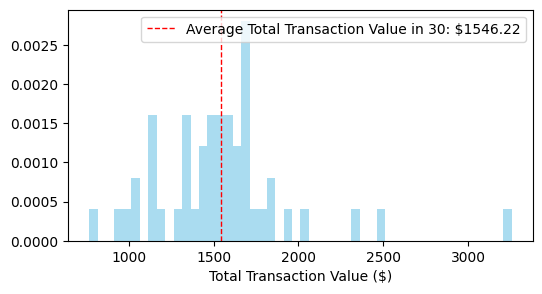

In [20]:
# Trials to finetune the profiles
profile_name = 'middle'
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile(profile_name)
print(profile_name)
print(customer.profile)

num_days = 30
num_trials = 50
total_txn_values = []
for trial in range(num_trials):
    customer_txns = customer.generate_batch_txns(num_days=num_days)
    total_txn_values.append(round(sum([txn["txn_value"] for txn in customer_txns]), 2))
# average total transaction value over all trials
avg_total_txn_value = round(np.mean(total_txn_values), 2)
print(f"Average total transaction value: ${avg_total_txn_value}")
# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(total_txn_values, bins=50, density=True, alpha=0.7, color="skyblue")
plt.xlabel("Total Transaction Value ($)")
# add average total transaction value to the plot
plt.axvline(
    avg_total_txn_value,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Average Total Transaction Value in {num_days}: ${avg_total_txn_value}",
)
plt.legend()

print("sample transactions")
print(customer_txns[0])

## 5. Generate a Set of Cumstomers and their legitimate transactions

1. Generate 100 customers with random profile
2. For each customer, generate 1 year of transactions


In [85]:
group_profiles

{'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
 'txn_mean_low': [5, 20, 40, 60, 80],
 'txn_mean_high': [20, 40, 60, 80, 100],
 'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
 'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
 'txn_lambda': [0.25, 0.5, 1, 1.5, 2]}

In [86]:
# generate txns for each customer
start_date="2024-01-01"
num_days=365
txn_data = []
customer_data = []
num_customers = 10000

for i in range(1,num_customers+1):
    # generate customer
    customer_id_num = 1000000 + i
    customer_id = f"c_{str(1000000 + i)[1:]}"
    customer_generator = CustomerGenerator(group_profiles)
    profile_name = random.choice(group_profiles["name"]) # random profile
    customer = customer_generator.generate_customer_from_profile(profile_name)

    # generate transactions for that customer
    customer_txns = customer.generate_batch_txns(num_days=num_days, start_date=start_date)

    # append to main dataset
    txn_data.append({"customer_id":customer_id, "customer_txns":customer_txns})
    customer_dict = customer.profile
    customer_dict["customer_id"] = customer_id
    customer_dict["profile_name"] = profile_name
    customer_data.append(customer_dict)

In [88]:
# POST-PROCESSING THE GENERATED DATA
# convert the dataset to a dataframe, with each row representing a transaction, and customer_id as a column
df_txns = pd.DataFrame(
    [
        {"customer_id": row["customer_id"], **txn}
        for row in txn_data
        for txn in row["customer_txns"]
    ]
)
# rearrange by timestamp to simulate the real-world scenario
df_txns.sort_values(by="txn_timestamp", inplace=True)
df_txns.reset_index(drop=True, inplace=True)

df_customers = pd.DataFrame(customer_data)

In [89]:
df_txns.head(5)

,customer_id,txn_id,txn_timestamp,txn_date,txn_value,txn_fraud,txn_fraud_scenario
0,c_006701,t_f981664c3e,2024-01-01 00:00:05,2024-01-01,54.86,0,0
1,c_007019,t_e22b0c1a8e,2024-01-01 00:00:36,2024-01-01,33.09,0,0
2,c_008982,t_ad09e8d091,2024-01-01 00:03:03,2024-01-01,185.80,0,0
3,c_004745,t_825d8abb52,2024-01-01 00:06:11,2024-01-01,85.92,0,0
4,c_004756,t_5d2faf2bc8,2024-01-01 00:06:34,2024-01-01,303.43,0,0


In [90]:
df_customers.head(5)

,txn_mean,txn_mu,txn_sigma,txn_lambda,customer_id,profile_name
0,40.90,3.599558,0.472381,1.00,c_000001,middle
1,40.56,3.587187,0.480823,1.00,c_000002,middle
2,86.04,4.250715,0.638901,2.00,c_000003,high
3,16.25,2.717300,0.376280,0.25,c_000004,low
4,64.25,3.977379,0.608937,1.50,c_000005,high-middle


## 6. Fraud Scenarios

In [ ]:
import numpy as np
from scipy.stats import norm

# Parameters of the underlying normal distribution
txn_mean = 100
mu = np.log(
    txn_mean
)  # The mu value in the log-normal distribution is the natural logarithm of the mean value of the original scale.
sigma = 0.7  # Standard deviation of the log

# GIVEN NUMBER OF SD, CALCULATE THE THRESHOLD VALUE AND % OF SAMPLES ABOVE THE THRESHOLD
# Threshold in terms of standard deviations from the mean
num_std_devs = 1.65

# Calculate the threshold value in the log-normal distribution
threshold = np.exp(mu + num_std_devs * sigma)

# Calculate the cumulative probability for the normal distribution
cdf_value = norm.cdf(mu + num_std_devs * sigma, loc=mu, scale=sigma)

# Calculate the percentage of samples above the threshold
percentage_above_threshold = (1 - cdf_value) * 100

print(f"Threshold value: {threshold}")
print(f"Percentage of samples above the threshold: {percentage_above_threshold:.2f}%")

# GIVEN THE PERCENTAGE OF SAMPLES, CALCULATE THE THRESHOLD VALUE AND NUMBER OF SD
# Percentage (e.g., 5% of samples above this value)
percentage = 5

# Calculate the quantile for the given percentage
quantile_value = norm.ppf(1 - percentage / 100, loc=mu, scale=sigma)

# Transform back to the original scale
threshold_value = np.exp(quantile_value)

# Calculate the number of Standard Deviations from the mean
num_std_devs = (quantile_value - mu) / sigma

print(f"Value above which there are {percentage}% of samples: {threshold_value}")
print(f"Number of standard deviations from the mean: {num_std_devs:.2f}")


def calculate_threshold(txn_mean: float, sigma: float, percentile: float):
    """
    Calculate the threshold value for a given percentile in a log-normal distribution.

    Parameters
    -----------
    txn_mean: float
        The transaction mean, in the original scale
    sigma: float
        The standard deviation of the log-normal distribution
    percentile: float
        The percentile value for which to calculate the threshold.
        E.g., 95 for 95th percentile, meaning 5% of samples are above this value.

    Returns
    --------
    float
        The threshold value for the given percentile
    """
    mu = np.log(txn_mean)
    quantile_value = norm.ppf(percentile / 100, loc=mu, scale=sigma)
    threshold_value = np.exp(quantile_value)
    return threshold_value.item()


calculate_threshold(txn_mean=100, sigma=0.7, percentile=99)

Threshold value: 317.4023417527599
Percentage of samples above the threshold: 4.95%
Value above which there are 5% of samples: 316.26096926215126
Number of standard deviations from the mean: 1.64


509.5936777167456

Monetary:
1. Every day, a number of customers is drawn at random. In the next 14 days, a fixed portion (e.g., 25%) of their transactions are randomly selected, multiplied by 10, and marked as fraudulent.

Recency, Frequency:

2. Large transactions in quick successions with increasing amounts

3. A small transaction followed by a few large transaction in quick successions

4. A large transaction followed by a small transaction. E.g., uniform(1000, 10000) followed by uniform(100, 1000) in 5 minutes.


### Scenario 1, 2, 3 Combined Without Pandas

In [122]:
class FraudulentTxnGenerator:
    """ 
    Class to generate fraudulent transactions for a given customer and date based on a specific scenario.
    """
    def __init__(self):
        self._date_format = "%Y-%m-%d"
        self._timestamp_format = "%Y-%m-%d %H:%M:%S"
        self._uuid_generator = UUIDGenerator(id_length=10)

    def generate_fraudulent_txns(
        self, customer_id:str, scenario: int, date: str
    ) -> List[dict]:
        """
        Generate a batch of fraudulent transactions for a given date.
        Scenario 1: Unusual large transactions scattered through a number of days
        Scenario 2: Large transactions in quick successions with increasing amounts.
        Scenario 3: A small transaction, followed by quick successions of a large amount.

        Parameters:
        -----------
        date: str
            The date of the transactions in the format 'YYYY-MM-DD'. E.g., '2024-01-01'

        Returns:
        --------
        List[dict]
            A list of dictionaries representing the fraudulent transactions
            E.g., [{'txn_id': 't_1', 'txn_timestamp': '2024-01-01 12:00:00', 'txn_value': 100.0, 'txn_fraud': 1, 'txn_fraud_scenario': 1}]
        """

        # Generate a random timestamp within the given date
        start_time = np.random.randint(0, 86400)  # Random second in the day (0 to 86400)

        # Convert the date string to a datetime object
        date_obj = datetime.strptime(date, self._date_format)

        # Generate the fraudulent transactions
        fraudulent_txns = []
        txn_value_increment = random.choice(range(500, 2000, 500))

        if scenario == 1:
            compromised_days = np.random.randint(5, 14)  # Can be converted to user's input later
            current_date = date_obj
            # for each day within the compromised days, generate a few transactions with large values
            # the large values are arbitrarily chosen to be "nice" numbers
            for _ in range(compromised_days):
                num_txns_day = np.random.randint(1, 3)
                for i in range(num_txns_day):
                    # txn_timestamp is a random time within the day
                    txn_timestamp = current_date + timedelta(
                        seconds=np.random.randint(0, 86400)
                    )
                    txn_date = txn_timestamp.strftime(self._date_format)
                    txn_timestamp = txn_timestamp.strftime(self._timestamp_format)
                    txn_value = round(
                        random.choice(range(500, 2000, 500)), 2
                    )  # Example transaction value

                    fraudulent_txns.append(
                        {
                            "customer_id": customer_id,
                            "txn_id": self._uuid_generator.generate_id(prefix="t_"),
                            "txn_timestamp": txn_timestamp,
                            "txn_date": txn_date,
                            "txn_value": txn_value,
                            "txn_fraud": 1,
                            "txn_fraud_scenario": 1,
                        }
                    )
                current_date += timedelta(days=1)

        elif scenario == 2:
            num_txns = np.random.randint(5,10)
            interval_seconds = np.random.randint(1, 5) * 60
            for i in range(num_txns):
                txn_timestamp = date_obj + timedelta(
                    seconds=start_time + i * np.random.randint(1, interval_seconds)
                )
                txn_date = txn_timestamp.strftime(self._date_format)
                txn_timestamp = txn_timestamp.strftime(self._timestamp_format)
                txn_value = round(
                    (i + 1) * txn_value_increment, 2
                )  # Example transaction value
                fraudulent_txns.append(
                    {
                        "customer_id": customer_id,
                        "txn_id": self._uuid_generator.generate_id(prefix="t_"),
                        "txn_timestamp": txn_timestamp,
                        "txn_date": txn_date,
                        "txn_value": txn_value,
                        "txn_fraud": 1,
                        "txn_fraud_scenario": 2,
                    }
                )
        elif scenario == 3:
            num_txns = np.random.randint(5,10)
            interval_seconds = np.random.randint(1, 5) * 60
            for i in range(num_txns):
                txn_timestamp = date_obj + timedelta(
                    seconds=start_time + i * np.random.randint(1, interval_seconds)
                )
                txn_date = txn_timestamp.strftime(self._date_format)
                txn_timestamp = txn_timestamp.strftime(self._timestamp_format)
                if i == 0:
                    txn_value = round(random.uniform(5, 10), 2)
                else:
                    txn_value = round(
                        txn_value_increment, 2
                    )  # use a fixed rounded number (for clearer difference from scenario 2)
                fraudulent_txns.append(
                    {
                        "customer_id": customer_id,
                        "txn_id": self._uuid_generator.generate_id(prefix="t_"),
                        "txn_timestamp": txn_timestamp,
                        "txn_date": txn_date,
                        "txn_value": txn_value,
                        "txn_fraud": 1,
                        "txn_fraud_scenario": 3,
                    }
                )
        else:
            raise ValueError("Invalid scenario number. Choose 1, 2 or 3.")
        return fraudulent_txns

In [123]:
# Example usage
fraudulent_txn_generator = FraudulentTxnGenerator()
fraudulent_txns = fraudulent_txn_generator.generate_fraudulent_txns(
    customer_id='c_10001', scenario=2, date="2024-01-01"
)
for txn in fraudulent_txns:
    print(txn)

{'customer_id': 'c_10001', 'txn_id': 't_f5abc9e9b1', 'txn_timestamp': '2024-01-01 14:34:56', 'txn_date': '2024-01-01', 'txn_value': 1000, 'txn_fraud': 1, 'txn_fraud_scenario': 2}
{'customer_id': 'c_10001', 'txn_id': 't_5fdf856718', 'txn_timestamp': '2024-01-01 14:35:45', 'txn_date': '2024-01-01', 'txn_value': 2000, 'txn_fraud': 1, 'txn_fraud_scenario': 2}
{'customer_id': 'c_10001', 'txn_id': 't_72b185fe10', 'txn_timestamp': '2024-01-01 14:38:02', 'txn_date': '2024-01-01', 'txn_value': 3000, 'txn_fraud': 1, 'txn_fraud_scenario': 2}
{'customer_id': 'c_10001', 'txn_id': 't_84887a4661', 'txn_timestamp': '2024-01-01 14:40:59', 'txn_date': '2024-01-01', 'txn_value': 4000, 'txn_fraud': 1, 'txn_fraud_scenario': 2}
{'customer_id': 'c_10001', 'txn_id': 't_2eb37d16cf', 'txn_timestamp': '2024-01-01 14:35:16', 'txn_date': '2024-01-01', 'txn_value': 5000, 'txn_fraud': 1, 'txn_fraud_scenario': 2}
{'customer_id': 'c_10001', 'txn_id': 't_a2ba98b6b1', 'txn_timestamp': '2024-01-01 14:49:16', 'txn_date': 

In [124]:
df_txns.head(3)

,customer_id,txn_id,txn_timestamp,txn_date,txn_value,txn_fraud,txn_fraud_scenario
0,c_006701,t_f981664c3e,2024-01-01 00:00:05,2024-01-01,54.86,0,0
1,c_007019,t_e22b0c1a8e,2024-01-01 00:00:36,2024-01-01,33.09,0,0
2,c_008982,t_ad09e8d091,2024-01-01 00:03:03,2024-01-01,185.80,0,0


In [104]:
# pick a customer_id and a txn_date
dates = df_txns["txn_date"].unique()
customer_id = 'c_000582'
date = random.choice(dates)
fraudulent_txns = fraudulent_txn_generator.generate_fraudulent_txns(
    customer_id=customer_id, scenario=1, date=date
)
# populate the customer_id to each transaction
for txn in fraudulent_txns:
    txn["customer_id"] = customer_id

pd.DataFrame(fraudulent_txns)

,customer_id,txn_id,txn_timestamp,txn_date,txn_value,txn_fraud,txn_fraud_scenario
0,c_000582,t_0cad26f24d,2024-11-12 21:43:54,2024-11-12,500,1,1
1,c_000582,t_59648f7ee0,2024-11-12 08:07:33,2024-11-12,500,1,1
2,c_000582,t_fc8dc9cfd1,2024-11-13 05:42:58,2024-11-13,500,1,1
3,c_000582,t_e756a7a2fe,2024-11-13 08:17:55,2024-11-13,500,1,1
4,c_000582,t_a2757cd74d,2024-11-14 21:30:56,2024-11-14,1000,1,1
5,c_000582,t_c70803cb1b,2024-11-14 14:08:53,2024-11-14,1000,1,1
6,c_000582,t_1e9ce11f7e,2024-11-15 05:36:21,2024-11-15,1000,1,1
7,c_000582,t_1a51c27ae4,2024-11-16 17:14:14,2024-11-16,1500,1,1
8,c_000582,t_65893141b4,2024-11-16 19:37:22,2024-11-16,1500,1,1
9,c_000582,t_bce7c7061a,2024-11-17 11:56:19,2024-11-17,1500,1,1


### Simulate fraudulent transactions


In [125]:
# pick random 10 customers from all customers
affected_customers = random.sample(df_customers["customer_id"].tolist(), 200)
dates = df_txns["txn_date"].unique()
# generate fraudulent transactions for each customer
fraudulent_txns = []
fraudulent_txn_generator = FraudulentTxnGenerator()
for customer_id in affected_customers:
    date = random.choice(dates)
    scenario = random.choice([1, 2, 3])
    fraudulent_txns.extend(
        fraudulent_txn_generator.generate_fraudulent_txns(
            customer_id=customer_id, scenario=scenario, date=date
        )
    )

In [127]:
pd.DataFrame(fraudulent_txns)

,customer_id,txn_id,txn_timestamp,txn_date,txn_value,txn_fraud,txn_fraud_scenario
0,c_009120,t_d534baf770,2024-05-24 06:04:00,2024-05-24,1500.0,1,2
1,c_009120,t_d1b9de4afd,2024-05-24 06:05:27,2024-05-24,3000.0,1,2
2,c_009120,t_eb87430014,2024-05-24 06:09:36,2024-05-24,4500.0,1,2
3,c_009120,t_d0e16b29ea,2024-05-24 06:08:33,2024-05-24,6000.0,1,2
4,c_009120,t_843dd06b76,2024-05-24 06:12:08,2024-05-24,7500.0,1,2
...,...,...,...,...,...,...,...
1822,c_008037,t_10b9ddfd00,2024-07-29 13:59:04,2024-07-29,7500.0,1,2
1823,c_008037,t_5c8704f238,2024-07-29 13:58:41,2024-07-29,9000.0,1,2
1824,c_008037,t_fdad312f04,2024-07-29 13:59:00,2024-07-29,10500.0,1,2
1825,c_008037,t_7bf100ea00,2024-07-29 14:01:10,2024-07-29,12000.0,1,2


In [117]:
len(fraudulent_txns)/len(df_txns)*100

0.04827563367490655